### Model selection (AIC, AICs, BIC)

This notebook provides: 

- [Tools-and-packages](#tools-and-packages)
- [Data loading](#data-loading) from [Kaggle](https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques/data) 
- [Data processing](#data-preprocessing)
    - Data reading and preprocessing
    - Data splitting
    - Data normalization
    - Visualizing data correlation
- [Implementing model (Linear regression or OLS)](#linear-regression-implementing-models)
- [Compute AIC, AICs, BIC](#compute-aic-aics-bic-on-training-data)
- [Performance on testing dataset (RSE, MSE)](#compute-performance-on-testing)
- [Model selection AIC, AICs, BIC, Adjusted R2 (using Training data)](#model-selection-aic-aics-bic-adjusted-r2)

You can run this notebook on collab:  <a target="_blank" href="https://colab.research.google.com/github/GenAI-CUEE/Statistical-Learning-EE575-Y2024/blob/master/Lab1/main.ipynb"> <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

### Tools and Packages

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt  

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler 
from sklearn import metrics  
import seaborn as sns

def train_validate_test_split(df, train_percent=.6, validate_percent=.2, seed=None):
    np.random.seed(seed) 
    perm         = np.random.permutation(df.index)
    m            = len(df.index) 
    train_end    = np.floor(int(train_percent * m))
    validate_end = np.floor(int(validate_percent * m) + train_end) 
    
    train        = df.iloc[perm[:train_end]]
    validate     = df.iloc[perm[train_end:validate_end]]
    test         = df.iloc[perm[validate_end:]] 

    train       = train.drop(columns=["index"])
    validate    = validate.drop(columns=["index"])
    test        = test.drop(columns=["index"])

    train       = train.reset_index(drop=True)
    validate    = validate.reset_index(drop=True)
    test        = test.reset_index(drop=True)
    
    return train, validate, test

### Data loading

In [2]:
foldername = "house-prices-advanced-regression-techniques"
df = pd.read_csv('%s/train.csv' % foldername)   
df.keys()

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

In [3]:
all_column = [  "MoSold",       "YrSold",       "MSSubClass",   "MSZoning",     "LandSlope",    "Condition1", "2ndFlrSF", 
                "HouseStyle",   "BldgType",     "Utilities",    "OverallCond",  "OverallQual",  "GrLivArea", "SaleCondition",
                "TotRmsAbvGrd", "TotalBsmtSF",  "BedroomAbvGr", "KitchenAbvGr", "FullBath",     "PoolArea",     
                "PavedDrive",   "HeatingQC",    "CentralAir",   "Fireplaces",   "Electrical",   'MiscFeature',     
                'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch',   "BsmtHalfBath", "ScreenPorch",  "MiscVal", "SalePrice"] 

Encoding string labels to numerical labels

In [4]:
df = df[all_column]
df = df.apply(LabelEncoder().fit_transform)

### Data preprocessing

1. Selecting input features

In [5]:
target_column = ["SalePrice"]
feat_column   = [  "MoSold",        "YrSold",        "MSZoning",     "LandSlope",   "2ndFlrSF", 
                   "CentralAir",    "TotRmsAbvGrd",  "TotalBsmtSF",  "GrLivArea",   "BldgType",    "Utilities",    
                   "OverallCond",   "BsmtHalfBath",  "ScreenPorch" ] 

2. Remove NaN ... 

In [6]:
df = df.dropna() 
df = df.reset_index()  

3. Data splitting

In [7]:
train, valid, test = train_validate_test_split(df, train_percent=.6, validate_percent=.2, seed=None)

4. Data normalization

In [8]:
X_scaler = StandardScaler() 
train[feat_column].values[:]        = X_scaler.fit_transform(train[feat_column].values[:] )
test[feat_column].values[:]         = X_scaler.transform(test[feat_column].values[:] )
valid[feat_column].values[:]        = X_scaler.transform(valid[feat_column].values[:] )

In [9]:
data_column =  target_column + feat_column
train_enc    = train.loc[:,data_column] 

5. Visualizing data correlation

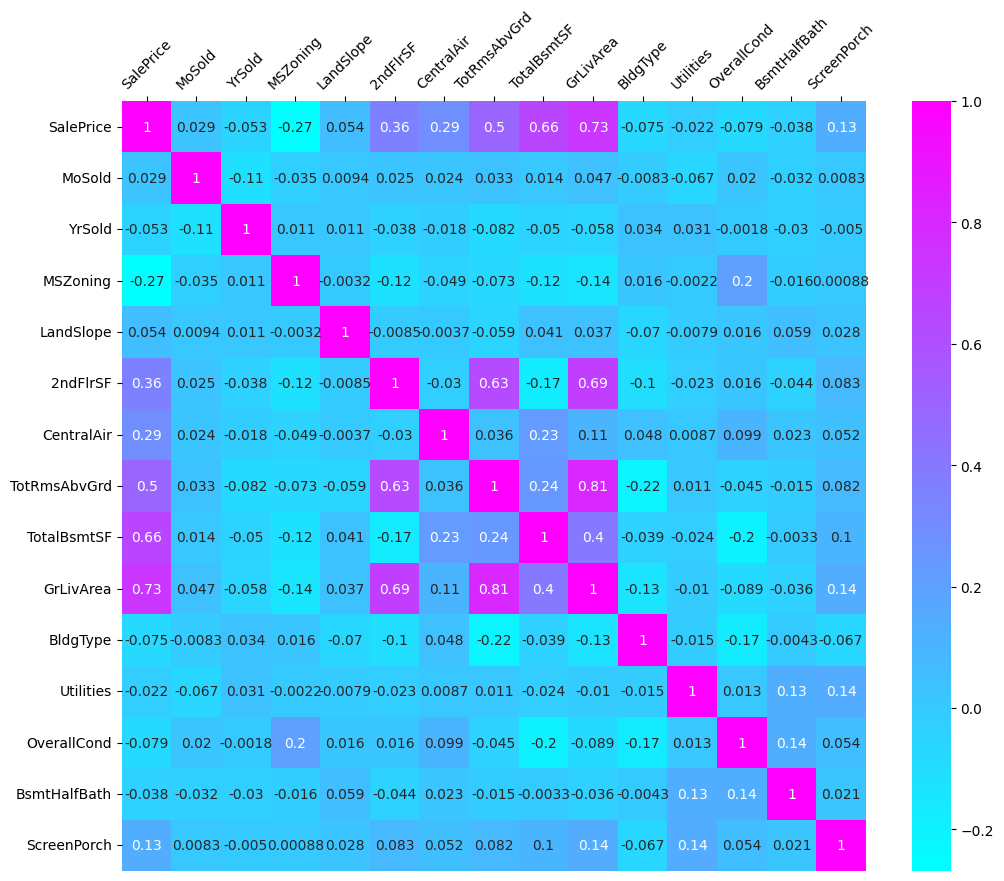

In [10]:
plt.figure(figsize=(12,10))
cor = train_enc.corr()
g = sns.heatmap(cor, annot=True, cmap=plt.cm.cool) 
g.axes.xaxis.set_ticks_position("top")
plt.setp(g.axes.get_xticklabels(), rotation=45)
plt.show()

### Linear regression (implementing models)

In [11]:
print("Feature Dimension dim:= %d" % len(feat_column))
print("Number Measurements (Training) m_{train}:= %d" % len(train))
print("Number Measurements (Training) m_{valid}:= %d" % len(valid))
print("Number Measurements (Testing)  m_{test}:= %d" % len(test))

Feature Dimension dim:= 14
Number Measurements (Training) m_{train}:= 876
Number Measurements (Training) m_{valid}:= 292
Number Measurements (Testing)  m_{test}:= 292


In [12]:
X_train = train[feat_column].values
y_train = train[target_column].values

X_valid = valid[feat_column].values
y_valid = valid[target_column].values

X_test = test[feat_column].values
y_test = test[target_column].values

Training model

In [13]:
from sklearn.linear_model import LinearRegression 

model_lr = LinearRegression()
model_lr.fit(X_train, y_train)  

LinearRegression()

### Compute AIC, AICs, BIC on training data

Compute likelihood score: $\mathcal{L}(\alpha) = - \frac{m}{2} \log{2 \pi \hat{\sigma}^2} - \frac{m}{2} $

In [14]:
def likelihood_score(y_training, y_expectation=None): 
    if y_expectation is None:
        y_expectation = np.mean(y_training)
    sigma_hat =  np.mean((y_training - y_expectation)**2)  
    m = len(y_training) 
    score     = - 0.5*m*np.log(2*np.pi*sigma_hat) - 0.5*m
    return score

In [15]:
y_train_predict = model_lr.predict(X_train)
ll_score = likelihood_score(y_train, y_expectation=y_train_predict) 

In [16]:
feat_dim  = len(feat_column)
num_train = len(y_train)

AIC / AICs score / BIC score / R2 score / Adjusted R^2

In [17]:
AIC_score  = -2*ll_score + 2*feat_dim
AICs_score = -2*ll_score + 2*feat_dim + 2*feat_dim*(feat_dim + 1)/(num_train - feat_dim - 1)
BIC_score  = -2*ll_score +  feat_dim*np.log(num_train)
RSS_score  = np.sum((y_train - y_train_predict)**2)
TSS_score  = np.sum((y_train - np.mean(y_train))**2)
R2_score   = 1 - RSS_score/TSS_score
AdjustR2_score = 1 - (RSS_score/(num_train-feat_dim-1))/(TSS_score/(num_train-1))

RSE

In [18]:
RSE_training = np.sqrt(RSS_score/(num_train - feat_dim))

MSE

In [19]:
MSE_training = np.mean((y_train - y_train_predict)**2)

In [20]:
print("Likelihood: %.4f" % -ll_score)
print("AIC  score: %.4f" % AIC_score)
print("AICs score: %.4f" % AICs_score)
print("BIC  score: %.4f" % BIC_score)
print("R2   score: %.4f" % R2_score)
print("Adjusted R2 score: %.4f" % AdjustR2_score) 
print("MSE  (training)  : %.4f" % MSE_training)
print("RSE  (training)  : %.4f" % RSE_training)

Likelihood: 5119.8674
AIC  score: 10267.7348
AICs score: 10268.2226
BIC  score: 10334.5899
R2   score: 0.7543
Adjusted R2 score: 0.7503
MSE  (training)  : 6983.5864
RSE  (training)  : 84.2437


### Compute performance on testing

In [21]:
y_test_predict = model_lr.predict(X_test) 

In [22]:
MSE_valid = np.mean((y_test - y_test_predict)**2)
RSS_valid = np.sum((y_test - y_test_predict)**2)
RSE_valid = np.sqrt(RSS_valid/(len(y_test) - feat_dim))

In [23]:
print("MSE (validation): %.4f" % MSE_valid)
print("RSE (validation): %.4f" % RSE_valid)

MSE (validation): 7065.5612
RSE (validation): 86.1474


## Model selection (AIC, AICs, BIC, Adjusted R2)

What is the most suitable set of features? 

In [24]:
target_column = ["SalePrice"]
feat_column_1   = ["MoSold",       "YrSold"  ]

feat_column_2   = ["MoSold",        "YrSold",       "MSSubClass"     ]

feat_column_3   = ["MoSold",        "YrSold",       "MSSubClass",     "LandSlope"  ]

feat_column_4   = ["MoSold",        "YrSold",       "MSSubClass",     "LandSlope",  
                   "ScreenPorch"  ]

feat_column_5   = ["MoSold",        "YrSold",       "MSSubClass",     "LandSlope",   
                   "ScreenPorch",   "MiscVal"  ]

feat_column_6   = ["MoSold",        "YrSold",       "MSSubClass",     "LandSlope",   
                   "ScreenPorch",   "MiscVal",      "Condition1"  ]

feat_column_7  = ["MoSold",        "YrSold",       "MSSubClass",     "LandSlope",   
                   "ScreenPorch",  "MiscVal",       "Condition1",   "OverallCond" ]

feat_column_8  = [ "MoSold",        "YrSold",       "MSSubClass",     "LandSlope",   
                   "ScreenPorch",  "MiscVal",         "Condition1",   "OverallCond",      
                   "KitchenAbvGr"  ]

feat_column_9  = [ "MoSold",        "YrSold",       "MSSubClass",     "LandSlope",   
                   "ScreenPorch",  "MiscVal",         "Condition1",   "OverallCond",      
                   "KitchenAbvGr",  "PoolArea" ]

feat_column_10  = ["MoSold",        "YrSold",       "MSSubClass",     "LandSlope",   
                   "ScreenPorch",  "MiscVal",       "Condition1",   "OverallCond",      
                   "KitchenAbvGr",  "PoolArea",     "Utilities"  ]


feature_set_dict = {1:feat_column_1, 2:feat_column_2, 3:feat_column_3, 4:feat_column_4, 5: feat_column_5, 
                    6:feat_column_6, 7:feat_column_7, 8:feat_column_8, 9:feat_column_9, 10: feat_column_10 }




In [25]:
from sklearn.linear_model import LinearRegression 
from sklearn.preprocessing import StandardScaler 

RMSE_training_set   = {}
RMSE_validation_set = {}

AIC_training_set = {}
AICs_training_set = {}
BIC_training_set = {}
AdjustedR2_training_set = {}

R2_training_set = {}
R2_validation_set = {}

for key, feat_set in feature_set_dict.items():


    X_scaler = StandardScaler() 
    train_X = X_scaler.fit_transform(train[feat_set].values[:] ) 
    valid_X = X_scaler.transform(valid[feat_set].values[:] ) 

    model_lr = LinearRegression()
    model_lr.fit(train_X, y_train)  

    y_train_pred = model_lr.predict(train_X) 
    y_valid_pred = model_lr.predict(valid_X) 

    ll_score = likelihood_score(y_train, y_expectation=y_train_pred) 
    
    num_train  = len(y_train)
    feat_dim = len(feat_set)

    AIC_score  = -2*ll_score + 2*feat_dim
    AICs_score = -2*ll_score + 2*feat_dim + 2*feat_dim*(feat_dim + 1)/(num_train - feat_dim - 1)
    BIC_score  = -2*ll_score +  feat_dim*np.log(num_train)
    
    RSS_score  = np.sum((y_train - y_train_pred)**2)
    TSS_score  = np.sum((y_train - np.mean(y_train))**2) 
    AdjustR2_score = 1 - (RSS_score/(num_train-feat_dim-1))/(TSS_score/(num_train-1))

    RSS_train = np.sum((y_train - y_train_pred)**2)
    RSE_train = np.sqrt(RSS_train/(len(y_train) - feat_dim))

    RSS_valid = np.sum((y_valid - y_valid_pred)**2)
    TSS_valid = np.sum((y_valid - np.mean(y_valid))**2) 
    RSE_valid = np.sqrt(RSS_valid/(len(y_valid) - feat_dim))

    RMSE_train  = np.sqrt(np.mean((y_train - y_train_pred)**2)) 
    RMSE_valid  = np.sqrt(np.mean((y_valid - y_valid_pred)**2)) 
 

    RMSE_training_set[key]   = RMSE_train
    RMSE_validation_set[key] = RMSE_valid 

    AIC_training_set[key]   = AIC_score
    AICs_training_set[key]  = AICs_score
    BIC_training_set[key]   = BIC_score
    AdjustedR2_training_set[key] = AdjustR2_score


Plotting bias-variance trade-off

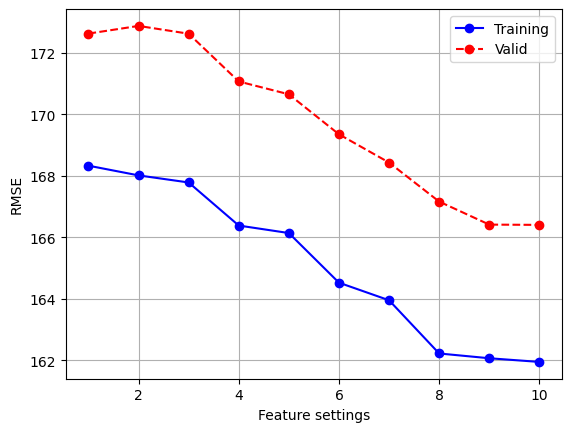

In [26]:
RMSE_training_lists = sorted(RMSE_training_set.items())  
feature_set, RMSE_training = zip(*RMSE_training_lists) 

RMSE_valid_lists = sorted(RMSE_validation_set.items())  
feature_set, RMSE_valid = zip(*RMSE_valid_lists) 

plt.plot(feature_set, RMSE_training, label="Training", color="blue", linestyle="-",  marker="o")
plt.plot(feature_set, RMSE_valid, label="Valid", color="red", linestyle = "--", marker="o")  
plt.xlabel("Feature settings")
plt.ylabel("RMSE")
plt.legend()
plt.grid()
plt.show()

Plot AIC, AICs, BIC, Adjusted R2

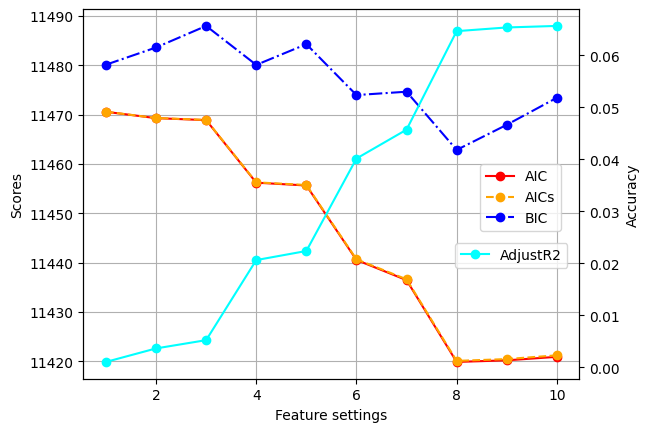

In [27]:
AIC_training_list = sorted(AIC_training_set.items())  
feature_set, AIC_training = zip(*AIC_training_list) 

AICs_training_list = sorted(AICs_training_set.items())  
feature_set, AICs_training = zip(*AICs_training_list) 

BIC_training_list = sorted(BIC_training_set.items())  
feature_set, BIC_training = zip(*BIC_training_list) 

AdjustedR2_training_list = sorted(AdjustedR2_training_set.items())  
feature_set, AdjustedR2_training = zip(*AdjustedR2_training_list) 

plt.plot(feature_set, AIC_training, label="AIC", color="red", linestyle="-",  marker="o")
plt.plot(feature_set, AICs_training, label="AICs", color="orange", linestyle = "--", marker="o")  
plt.plot(feature_set, BIC_training, label="BIC", color="blue", linestyle = "-.", marker="o")  
plt.ylabel("Scores") 
plt.legend(loc=(0.8,0.4))
plt.xlabel("Feature settings")
plt.grid()

plt.gca().twinx().plot(feature_set, AdjustedR2_training, label="AdjustR2", color="cyan", linestyle = "-", marker="o")  
plt.ylabel("Accuracy") 
plt.legend(loc=(0.75,0.30))  
plt.gca().xaxis.grid(True)
plt.show()